In [1]:
import json
import pandas as pd
import numpy as np
import re

In [2]:
from sklearn.metrics import accuracy_score, f1_score

# from utils import TextCleaner, CleanTwitter
import string
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
import warnings
from utils import print_confusion_matrix
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")

In [3]:
train = pd.read_json("data/interim/train-large.json")
train.head()

,uid,sentiment,text
0,8,neutral,RT @ UAAPconfessions Love looks good on Maddie...
1,12,neutral,Ye Ye ..... ye ??????? We gonna start another ...
2,14,neutral,@ zWffFY9JGklElA1 @ Min _ Of _ Lyching @ thaku...
3,23,negative,~ Caring . ~ Bohot Jyada Caring . ~ Courier wa...
4,24,positive,@ AliHZaidiPTI @ SarfarazA _ 54 What nonesense...


In [4]:
num_classes = len(set(list(train['sentiment']))); num_classes

3

In [5]:
def cleaner(train):
    train["clean_text"] = train["text"]
    train["clean_text"] = (
        (train["clean_text"])
        .apply(lambda text: re.sub(r"RT\s@\s\w+", "", text))
        .apply(lambda text: re.sub(r"@", "mention", text))
        .apply(lambda text: re.sub(r"#", "hashtag", text))
        .apply(lambda text: re.sub(r"http\S+", "", text))
    )

    le = LabelEncoder()
    train["target"] = le.fit_transform(train["sentiment"])
    print(f"Classes : {le.classes_}")
    X_train, X_test, y_train, y_test = train_test_split(
        train["clean_text"].values,
        train["target"].values,
        test_size=0.25,
        random_state=0,
    )

    vect = TfidfVectorizer(
        strip_accents="unicode",
        ngram_range=(1, 2),
        max_df=0.75,
        min_df=3,
        sublinear_tf=True,
    )

    tfidf_train = vect.fit_transform(X_train)
    tfidf_test = vect.transform(X_test)

    return X_train, X_test, y_train, y_test, tfidf_train, tfidf_test, le.classes_

In [6]:
%time X_train, X_test, y_train, y_test, tfidf_train, tfidf_test, label_classes = cleaner(train)

Classes : ['negative' 'neutral' 'positive']
CPU times: user 2.56 s, sys: 106 ms, total: 2.67 s
Wall time: 2.76 s


# Naive Bayes

In [7]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ["_r", "_clf"])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ["_r", "_clf"])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y == y_i].sum(0)
            return (p + 1) / ((y == y_i).sum() + 1)

        self._r = sparse.csr_matrix(np.log(pr(x, 1, y) / pr(x, 0, y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(
            C=self.C, dual=self.dual, n_jobs=self.n_jobs
        ).fit(x_nb, y)
        return self

In [8]:
NBSVM = NbSvmClassifier(C=4, dual=False, n_jobs=-1).fit(tfidf_train, list(y_train))

test accuracy: 0.60188
test f1_score: 0.60658


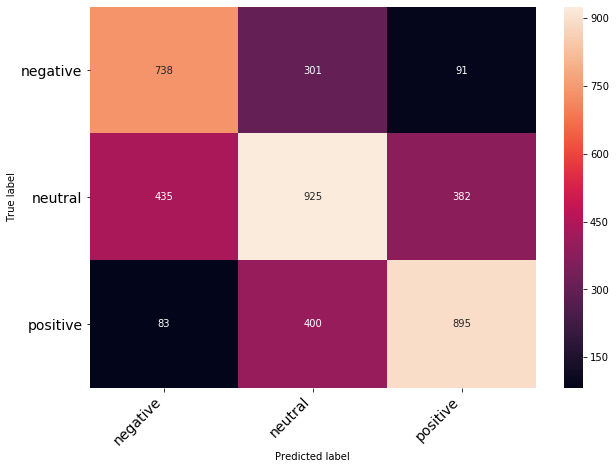

In [9]:
pred = NBSVM.predict(tfidf_test)
print("test accuracy:", round(accuracy_score(pred, y_test), 5))
print("test f1_score:", round(f1_score(pred, y_test, average="macro"), 5))
cm = confusion_matrix(pred, y_test)
print_confusion_matrix(cm, class_names=label_classes)

# Logistic Regression with TF-IDF

In [10]:
LR = LogisticRegression(C=4, dual=False, solver="lbfgs", max_iter=1000)

test accuracy: 0.59529
test f1_score: 0.60031


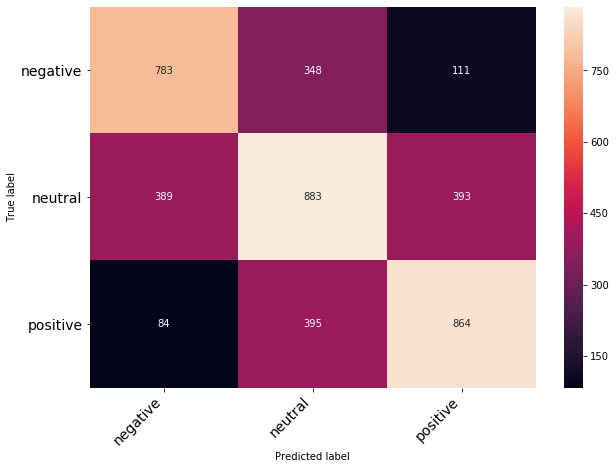

In [11]:
_ = LR.fit(tfidf_train, y_train)
pred = LR.predict(tfidf_test)
print("test accuracy:", round(accuracy_score(pred, y_test), 5))
print("test f1_score:", round(f1_score(pred, y_test, average="macro"), 5))
cm = confusion_matrix(pred, y_test)
print_confusion_matrix(cm, class_names=label_classes)

# With Cleanlab?

In [12]:
from cleanlab.classification import LearningWithNoisyLabels
from cleanlab.noise_generation import generate_noise_matrix_from_trace
from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import value_counts
from cleanlab.latent_algebra import compute_inv_noise_matrix
import cleanlab

In [13]:
# Set the sparsity of the noise matrix.
FRAC_ZERO_NOISE_RATES = 0.5
# A proxy for the fraction of labels that are correct.
avg_trace = 0.95  # ~5% wrong labels. Increasing makes the problem easier.

p_y = value_counts(y_train)  # probability of y estimates
noise_matrix = generate_noise_matrix_from_trace(
    K=num_classes,
    trace=num_classes * avg_trace,
    py=p_y,
    frac_zero_noise_rates=FRAC_ZERO_NOISE_RATES,
)

# Create noisy labels
s = generate_noisy_labels(y_train, noise_matrix)

## NB-SVM Regular Train Labels 

NB-SVM Regular Train Labels confident learning (noise matrix given), test accuracy: 0.58588
test f1_score: 0.58884


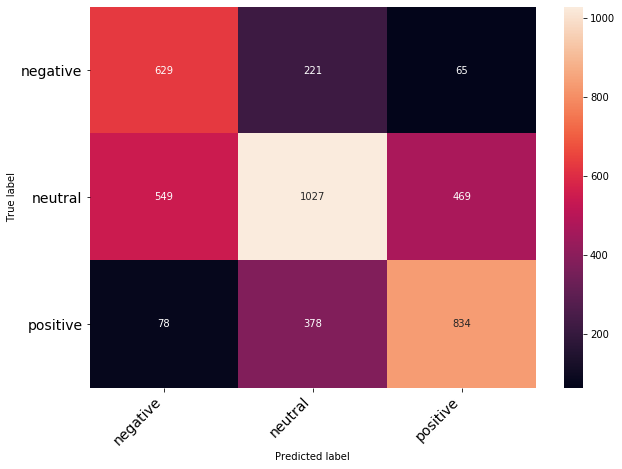

In [14]:
print("NB-SVM Regular Train Labels confident learning (noise matrix given),", end=" ")
NBSVM_Confident = NbSvmClassifier(C=4, dual=False, n_jobs=-1)
rp = LearningWithNoisyLabels(clf=NBSVM_Confident)
_ = rp.fit(tfidf_train, y_train, noise_matrix=noise_matrix)
pred = rp.predict(tfidf_test)
print("test accuracy:", round(accuracy_score(pred, y_test), 5))
print("test f1_score:", round(f1_score(pred, y_test, average="macro"), 5))
cm = confusion_matrix(pred, y_test)
print_confusion_matrix(cm, class_names=label_classes)

## LR Regular Train Labels 

LR Regular Train Labels confident learning (noise matrix given), test accuracy: 0.60753
test f1_score: 0.61235


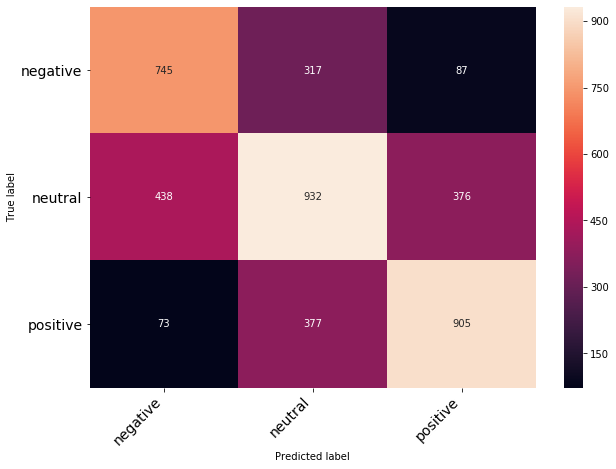

In [15]:
print("LR Regular Train Labels confident learning (noise matrix given),", end=" ")
LR = LogisticRegression(C=4, dual=False, solver="lbfgs", max_iter=1000)
rp = LearningWithNoisyLabels(clf=LR)
_ = rp.fit(tfidf_train, y_train, noise_matrix=noise_matrix)
pred = rp.predict(tfidf_test)
print("test accuracy:", round(accuracy_score(pred, y_test), 5))
print("test f1_score:", round(f1_score(pred, y_test, average="macro"), 5))
cm = confusion_matrix(pred, y_test)
print_confusion_matrix(cm, class_names=label_classes)

## NB-SVM Noisy Train Labels 

NB-SVM Noisy Train Labels confident learning (noise matrix given), test accuracy: 0.58329
test f1_score: 0.58653


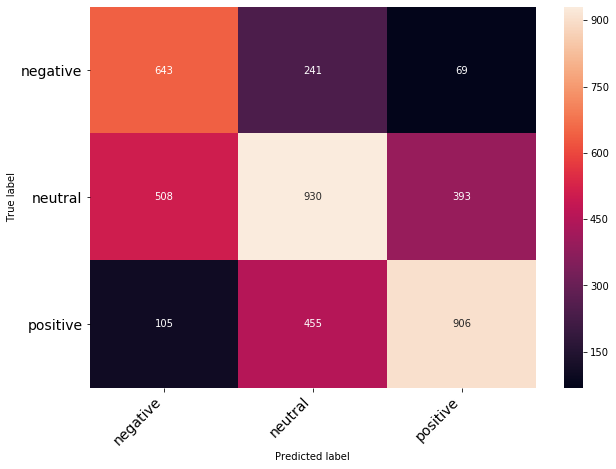

In [16]:
print("NB-SVM Noisy Train Labels confident learning (noise matrix given),", end=" ")
NBSVM_Confident = NbSvmClassifier(C=4, dual=False, n_jobs=-1)
rp = LearningWithNoisyLabels(clf=NBSVM_Confident)
_ = rp.fit(tfidf_train, s, noise_matrix=noise_matrix)
pred = rp.predict(tfidf_test)
print("test accuracy:", round(accuracy_score(pred, y_test), 5))
print("test f1_score:", round(f1_score(pred, y_test, average="macro"), 5))
cm = confusion_matrix(pred, y_test)
print_confusion_matrix(cm, class_names=label_classes)

## LR Noisy Train Labels 

LR Noisy Train Labels confident learning (noise matrix given), test accuracy: 0.59435
test f1_score: 0.59823


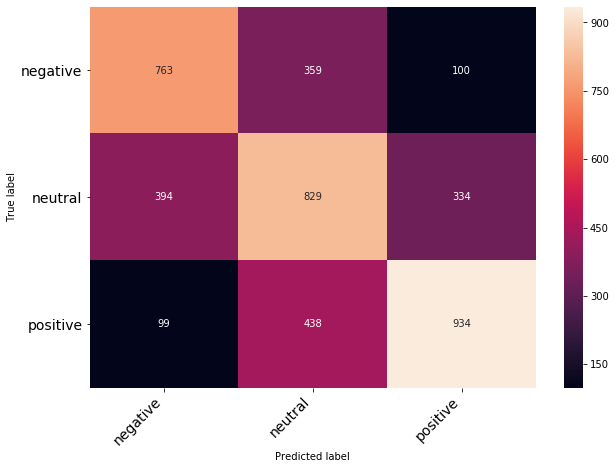

In [17]:
print("LR Noisy Train Labels confident learning (noise matrix given),", end=" ")
LR = LogisticRegression(C=4, dual=False, solver="lbfgs", max_iter=1000)
rp = LearningWithNoisyLabels(clf=LR)
_ = rp.fit(tfidf_train, s, noise_matrix=noise_matrix)
pred = rp.predict(tfidf_test)
print("test accuracy:", round(accuracy_score(pred, y_test), 5))
print("test f1_score:", round(f1_score(pred, y_test, average="macro"), 5))
cm = confusion_matrix(pred, y_test)
print_confusion_matrix(cm, class_names=label_classes)